<a href="https://www.kaggle.com/code/mkanothe/deriving-nn-from-linear-and-quadratic-equations?scriptVersionId=157113136" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# Foundation of Training Neural Nets in DL - Using Gradient Descent and MSE

This notebook is based on Fastai's [Lesson 3: Practical Deepl Learning for coders 2022 - YouTube Link](https://youtu.be/hBBOjCiFcuo?si=2KlQgQfvNhKJsqy0) by Jeremy Howard.

A **neural network** is just a mathematical function. In the most standard kind of a neural network, the function:
1. Multiplies each input by a number of values. These values are known as parameters.
2. Adds them up for each group of values.
3. Replaces the negative numbers with zeros.

This represents on _"layer"_ of the neural net. Then these three steps are repeated, using outputs of the previous layer as the inputs to the next layer. Initially, the parameters in this function are selected randomly. Therefore, a newly created neural network does not do anything useful at all -- it's just random!

To get this neural network function to _"learn"_ to do something useful, we have to change the parameters to make them "better" in some way.
We do this using **gradient descent**. Let's see how this work.

## **Fitting a function with _gradient descent_**

In [4]:
from ipywidgets import interact
from fastai.basics import *

plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min, max, 100)[:,None]
    
    if ylim:
        plt.ylim(ylim)
    
    plt.plot(x, f(x), color)
    
    if title is not None:
        plt.title(title)

To learn how a gradient descent works, we are going to start by fitting a quadratic, since that is a function most of us are probably more familiar with than a neural network.

Plotting the quadratic function:

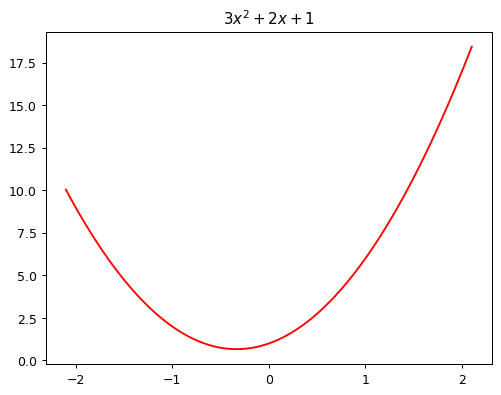

In [5]:
def quadrtc_fn(x):
    return 3*x**2 + 2*x + 1

plot_function(quadrtc_fn, "$3x^2 + 2x + 1$")

Imagine we don't know the values of the quadrtc_fn() above. Instead, we are trying to recreate it. This is the general idea of training a model.

The above quadratic is of the form **ax^2 + bx + c**, with parameters **a = 3, b= 2, c = 1**. To make it easier to try out different quadratics for fitting a model to the data we will create, let's create a function that calculates the value of a point on any quadratic.

Let's see what we can achieve:

In [6]:
# Create a general quadratic function
def quad(a, b, c, x):
    return a*x**2 + b*x + c

Now let's call the `quad(*params)` function with some random values for parameters:

In [8]:
# calling the function using the earlier params of a,b,c
quad(3,2,1, 1.5)

10.75

In [9]:
from functools import partial # helps make quadratic functions

def mk_quad(a,b,c):
    return partial(quad, a,b,c)

f_example = mk_quad(3,2,1)
f_example(1.5) # -> passing in the value of x cos the others (a,b,c) are already fixed.


10.75

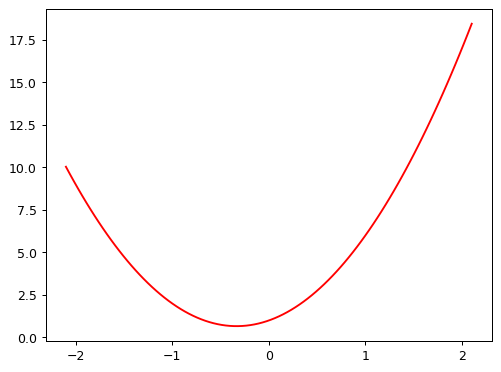

In [10]:
# let's plot the above example
plot_function(f_example)

Now let's create a sumulation of noisy measurements of our quaratic function. We will use gradient descent to see if we can recreate the original function from the data.

But first, a couple of functions to add some random noise to the data.

In [11]:
# Fit a function by good hands and eyes - Manually changing the parameters a, b, c
from numpy.random import normal, seed, uniform

np.random.seed(42) # set the seed to ensure we always get the same random numbers

def noise(x, scale):
    # create normally distributed random numbers
    return normal(scale=scale, size=x.shape)

def add_noise(x, mult, add):
    return x * (1 + noise(x, mult)) + noise(x, add)


Plotting some data that matches the shape of mk_quad et al functions.

This will create a noisy measurements based on quadratic above.

In [12]:
# plot the quadratic function using
x = torch.linspace(-2, 2, steps=20)[:, None] # creates a tensor - a vector going from -2 to 2 in 20 equal steps
y = add_noise(f_example(x), 0.3, 1.5)

In [13]:
x[:5],y[:5]

(tensor([[-2.0000],
         [-1.7895],
         [-1.5789],
         [-1.3684],
         [-1.1579]]),
 tensor([[12.5396],
         [ 6.3975],
         [ 6.4566],
         [ 3.5170],
         [ 1.6997]], dtype=torch.float64))

The values of x and y are _tensors_. A tensor is just like an `array` in numpy.

A tensor can be a single number _(a scalar or rank-0 tensor)_, a list of number _(a vector or rank-1 tensor)_, a table of numbers _(a matrix or rank-2 tensor)_, and so forth.

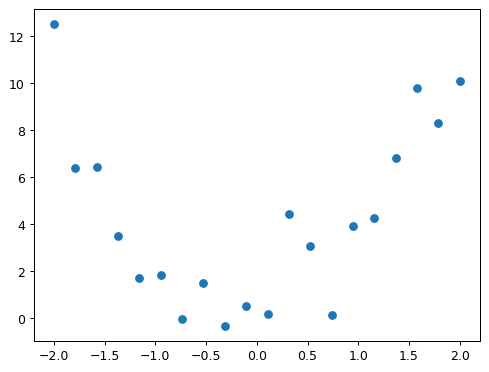

In [14]:
plt.scatter(x,y)

Now, we have some data.
We will try to reconstruct the original quadratic equation. How do we do that?
_Let's fuck around, and find out_

In [15]:
# interact with the parameters to change them
from ipywidgets import interact

@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a, b, c):
    """We overlay a quadratic on top of our data, along with some sliders to change the parameters a, b, and c"""
    plt.scatter(x,y)
    plot_function(mk_quad(a, b, c), ylim=(-3, 12))

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

NOW WE AUTOMATE:

The first step:
We need to know, if we increase (or decrease) the value of a parameter, does it get better or worse?

Introducing the loss functions. These will help with automatically updating the parameters.

Loss function tells us whether the current value of the function and parameters is better or worse than the actual. - relative to making better predictions.

In [16]:
# main squared error (mse) - a simple and common loss function
def mse(predictions, actuals):
    return ((predictions - actuals)**2).mean()


In [17]:
# plot the quadratic function with manual parameters but including a display of the loss function
@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a, b, c):
    f = mk_quad(a, b, c)
    plt.scatter(x, y)
    loss = mse(f(x), y)
    plot_function(f, ylim=(-3, 12), title=f"MSE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

## **Automating gradient discent**

Finally, Automating.
The key thing to remember is we want to know, `does the loss get better when we increase or decrease the input?`.

Another way to see if the loss function is getting better, _other than the manual way of changing the parameters(input),_ is by calculating its **derivative**.

A derivative is a function that tells us, _if we increase the input, does the output increases or decreases, and by how much_. That is called the slope or the gradient.

Pytorch calculates the derivative automatically.

In [18]:
# Automate the search of parameters for better loss.

# a func that takes coefficients of the quad and returns the mse of predictions and actuals
def quad_mse(params):
    f = mk_quad(*params)
    return mse(f(x), y) # the loss of the quadratic function

quad_mse([1.5, 1.5, 1.5])
# returns: - 1d tensor


tensor(5.8336, dtype=torch.float64)

In pytorch, everything is a tensor.
- 1D tensor - `[1, 2, 3]` - lists and vectors of numbers
- 2D tensor - rectangles and tables of numbers
- 3D tensors - Layers of tables of numbers
- etc

In [20]:
# create all the coefficients and put them in a single 1D - rank1 tensor
abc = torch.tensor([1.5, 1.5, 1.5])
abc.requires_grad_() # tell pytorch to calculate the gradient of these numbers whenever we use them in a calculation

# return a tensor

tensor([1.5000, 1.5000, 1.5000], requires_grad=True)

In [21]:
# use it in a calculation
loss = quad_mse(abc)
loss
# display a tensor with a grad_fn(gradient function)

tensor(5.8336, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [22]:
# calculate the gradient
loss.backward()

In [23]:
# access the calculated gradient
abc.grad

tensor([-5.1419,  2.8472, -1.1009])

In [24]:
# the gradient displays a tensor that shows the loss is still big.
# Now we reduce it

with torch.no_grad(): # tell pytorch not to calc gradient of abc params
    abc -= abc.grad*0.01 # updating the gradients - learning rate hyper-parameter
    loss = quad_mse(abc) # calculate loss

print(f"loss={loss:.2f}") # outputs 10.59

loss=5.49


Now we have update the parameters in one cycle. Let's Automate the whole thing.

In [25]:
# The mathematical function
# we will repeat for five times - This is called Optimization using Gradient descent
for i in range(5):
    loss = quad_mse(abc)
    loss.backward()
    with torch.no_grad():
        abc -= abc.grad*0.01 # 0.01 is the learning rate used to update the params
    
    print(f"step={i}; loss={loss:.2f}")

step=0; loss=5.49
step=1; loss=4.90
step=2; loss=4.23
step=3; loss=3.67
step=4; loss=3.33


As observed the loss keeps going down.

Here is the basic principle:

- We have parameters initialized with random values.
- We use a loss function to calculate the loss, i.e., compare the prediction with the actual value.
- We calculate the gradients of each of the parameters and decrease them to decrease the loss. _This leads to improvement in predictions or the difference between actual and prediction comes down._

_**NB**: If we keep learning the loop for long enough, the loss eventually starts to increase. This is because as the parameters get close to the correct answer, the updates skip the right answer and go to the values immediately past. Therefore, as we train the model, we decrease the learning rate value using **learning rate schedule**._

_Learning rate_ is the most important hyper-parameter to set when training a neural network function.

This is a basic principle of optimizers in deep learning and ML.
This principle of optimization is called _gradient descent_, because we calculate the gradient and the we try to do a descent.

And that is it. _*How to find parameters for the model*_ 

We need one more thing. _What is the mathematical function, that we are finding these parameters for?_ We can't just use quadratics, right?

## **How a neural network approximates any given function**

Enters, **Rectified Linear Function**

In [26]:
# infitely flexible function called Rectified Linear Unit
def rectified_linear(m,b,x):
    y = m*x + b # linear function
    return torch.clip(y, 0.) # if y<0: y = 0

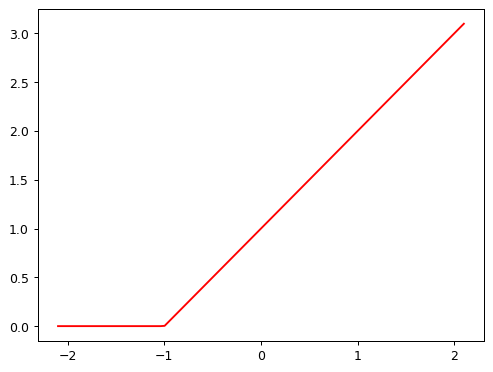

In [27]:
# plot it
plot_function(partial(rectified_linear, 1, 1)) # 

Instead of `torch.clip(y,0.)`, we can use `F.relu(x)`, where `F` is `torch.nn.functional` module.

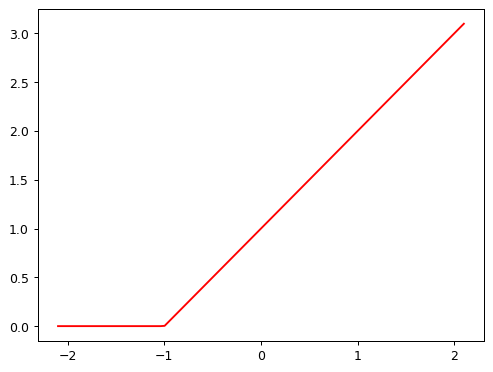

In [29]:
import torch.nn.functional as F

def rectified_linear2(m,b,x):
    return F.relu(m*x+b)

plot_function(partial(rectified_linear2, 1,1))

Let's make it interactive and explore parameters `a` and `m`:

In [31]:
@interact(m=1.5, b=1.5)
def plot_relu(m, b): # plot rectified linear unit
    plot_function(partial(rectified_linear, m, b), ylim=(-1,4))

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

Add two ReLU together.

In [32]:
def double_relu(m1, b1, m2, b2, x):
    return rectified_linear(m1, b1, x) + rectified_linear(m2, b2, x)

In [33]:
# plot them
@interact(m1=1.5, b1=1.5, m2=1.5, b2=1.5)
def plot_double_relu(m1,b1,m2,b2):
    plot_function(partial(double_relu, m1,b1,m2,b2), ylim=(-1,6))

interactive(children=(FloatSlider(value=1.5, description='m1', max=4.5, min=-1.5), FloatSlider(value=1.5, desc…

Now, We can do the same using as extremely many relus, not just two.

We use gradient descent to get the parameters.

This is the principle or foundation or the proof or the concept or the deriving of deep learning.

Everything else is just how to make it faster and make it need less data.

Consider the analogy of how to draw an owl. _You fast draw two circles and then draw the rest of the damn owl._

In the context of deep learning, Jeremy Howard states that: _"When you have ReLUs getting added together, and gradient descent to optimize the parameters, and samples of inputs and outputs that you want, the computer draws the owl."_

## Matrix Multiplication
The first Case of Optimization and making it easier is **Matrix Multiplication**

Matrix multiplication is the most critical mathematical operation in basically all of deep learning. It is basically multiplying things together and adding them up.
If we have any negatives in the product of the matrix multiplication, we convert it into zero.

- GPUs are good in matrix multiplication, because they have tensor cores which only multiply four by four matrices.

# # Practice
- It is time to take on the **Titanic** competition on [Kaggle.com](https://www.kaggle.com/competitions/titanic/data?select=train.csv)


### Next UP
[Getting started with NLP for absolute beginners](https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners)